#OLS Ridge and Lasso

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import io
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1bcu2TSWXPFedsnmQV2BppNpnMU6YC6Qv' # The id File
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FINAL_MASTER.csv')  
df = pd.read_csv('FINAL_MASTER.csv')


In [0]:
df.head()

,artist,date,weekday,promoter,SG_venue,venue_city,venue_state,TM_max,SG_max_price,TM_min,...,daystoconcert,segment,genre,subGenre,Capture_date,SG_listing_count,SG_venue_score,max_pop,max_follow,SG_artists_score
0,Lake Street Dive,1/15/2019,Tuesday,PROMOTED BY VENUE,Ponte Vedra Concert Hall,Ponte Vedra Beach,FL,34.5,36.0,34.5,...,0,Music,Rock,Alternative Rock,1/15/2019,3,0.466979,64,191086,0.56
1,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,109.0,25.0,...,1,Music,Rock,Alternative Rock,1/15/2019,35,0.503499,41,19707,0.39
2,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,68.0,25.0,...,0,Music,Rock,Alternative Rock,1/16/2019,5,0.503499,41,19746,0.39
3,Dylan Scott,1/17/2019,Thursday,LIVE NATION MUSIC,Gramercy Theatre,New York,NY,50.5,286.0,30.5,...,2,Music,Country,Country,1/15/2019,14,0.515187,66,372825,0.49
4,Vertical Horizon,1/17/2019,Thursday,PROMOTED BY VENUE,Highline Ballroom,New York,NY,75.0,217.0,35.0,...,2,Music,Rock,Alternative Rock,1/15/2019,10,0.506355,56,184769,0.42


#Data cleaning

In [0]:
##Removing rows accordingly to our data cleaning process
#Remove max popularity < 10
#Remove max followers <10
#Remove data points with average price > 400 (IQR 0.75 - 0.25 + Mean)
#Drop any lines with NA, None
#Remove venue score 0 and artist score 0

df = df[df['SG_average_price'] > 0]

df=df[df['SG_average_price'] <= 400]

df=df[df['max_pop'] >=10]

df=df[df['max_follow'] >=10]

df=df[df['SG_venue_score'] >=0.1]

df=df[df['SG_artists_score'] >=0.1]



In [0]:
#drop NAs
df.isna().sum()
df= df.dropna()
df.isna().sum()


artist              0
date                0
weekday             0
promoter            0
SG_venue            0
venue_city          0
venue_state         0
TM_max              0
SG_max_price        0
TM_min              0
SG_min_price        0
SG_average_price    0
daystoconcert       0
segment             0
genre               0
subGenre            0
Capture_date        0
SG_listing_count    0
SG_venue_score      0
max_pop             0
max_follow          0
SG_artists_score    0
dtype: int64

In [0]:
df.shape

(11861, 22)

In [0]:
#Change to numeric

df["SG_artists_score"] = pd.to_numeric(df["SG_artists_score"])
df["SG_venue_score"] = pd.to_numeric(df["SG_venue_score"])
df["max_pop"] = pd.to_numeric(df["max_pop"])
df["max_follow"] = pd.to_numeric(df["max_follow"])
df["daystoconcert"] = pd.to_numeric(df["daystoconcert"])
df["SG_average_price"] = pd.to_numeric(df["SG_average_price"])

#Change text object to String

df[["promoter", "genre","subGenre","venue_city","venue_state","SG_venue","weekday"]] = df[["promoter", "genre","subGenre","venue_city","venue_state", "SG_venue","weekday"]].astype(str) 


#Coerce string to categories
df["promoter"] = df["promoter"].astype('category')
df["genre"] = df["genre"].astype('category')
df["subGenre"] = df["subGenre"].astype('category')
df["venue_city"] = df["venue_city"].astype('category')
df["venue_state"] = df["venue_state"].astype('category')
df["weekday"] = df["weekday"].astype('category')
df["SG_venue"] = df["SG_venue"].astype('category')


In [0]:
df.dtypes

artist                object
date                  object
weekday             category
promoter            category
SG_venue            category
venue_city          category
venue_state         category
TM_max               float64
SG_max_price         float64
TM_min               float64
SG_min_price         float64
SG_average_price     float64
daystoconcert          int64
segment               object
genre               category
subGenre            category
Capture_date          object
SG_listing_count       int64
SG_venue_score       float64
max_pop                int64
max_follow             int64
SG_artists_score     float64
dtype: object

In [0]:
#from google.colab import files
#df.to_csv('df.csv')
#files.download('df.csv')

end of basic data cleaning

---



#OLS Model

In [0]:
#import libraries for modeling
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [0]:
#Removing target column from ORIGINAL DF

##Data
#Output is Type pandas df
X = df[['SG_artists_score',
'venue_city',
'SG_venue_score',
'venue_state',
'max_pop',
'max_follow',
'daystoconcert',
        "genre",
       "weekday"]]

#Target
#Output is Type pandas df
Y = df[['SG_average_price']].astype(int)



In [0]:
X.head()

,SG_artists_score,venue_city,SG_venue_score,venue_state,max_pop,max_follow,daystoconcert,genre,weekday
0,0.56,Ponte Vedra Beach,0.466979,FL,64,191086,0,Rock,Tuesday
1,0.39,Philadelphia,0.503499,PA,41,19707,1,Rock,Wednesday
2,0.39,Philadelphia,0.503499,PA,41,19746,0,Rock,Wednesday
3,0.49,New York,0.515187,NY,66,372825,2,Country,Thursday
4,0.42,New York,0.506355,NY,56,184769,2,Rock,Thursday


In [0]:
#One Hot! 


dummies1 = pd.get_dummies(df['promoter'])
X= pd.concat([X,dummies1],axis=1)

dummies2 = pd.get_dummies(df['genre'])
X= pd.concat([X,dummies2],axis=1)

dummies3 = pd.get_dummies(df['subGenre'])
X= pd.concat([X,dummies3],axis=1)

dummies4 = pd.get_dummies(df['venue_city'])
X= pd.concat([X,dummies4],axis=1)

dummies5 = pd.get_dummies(df['venue_state'])
X= pd.concat([X,dummies5],axis=1)

dummies6 = pd.get_dummies(df['weekday'])
X= pd.concat([X,dummies6],axis=1)



In [0]:
#DROP COLUMNS THAT WE USE GET DUMMIES ON

X.drop(columns=['genre','venue_city','venue_state','weekday' ], inplace=True)


In [0]:
#Check if columns were removed
X.head()

,SG_artists_score,SG_venue_score,max_pop,max_follow,daystoconcert,191 TOURING,AEG - TICKETING,AEG LIVE,AL WASH,ANDREW HEWITT & BILL SILVA PRESENTS,...,PA,TN,TX,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.56,0.466979,64,191086,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.39,0.503499,41,19707,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0.39,0.503499,41,19746,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.49,0.515187,66,372825,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.42,0.506355,56,184769,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Spliting data into test and train


In [0]:
##Import function for splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2,random_state=1)

In [0]:
print ("X.shape:", X.shape)
print ("Y.shape:", Y.shape)
print ("X_train.shape:", X_train.shape)
print ("X_test.shape:", X_test.shape)
print ("y_train.shape:", y_train.shape)
print ("y_test.shape:", y_test.shape)

X.shape: (11861, 230)
Y.shape: (11861, 1)
X_train.shape: (9488, 230)
X_test.shape: (2373, 230)
y_train.shape: (9488, 1)
y_test.shape: (2373, 1)


##Fitting, training and predicting models.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [0]:
# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 2599.57
Variance score: 0.53


In [0]:
regr.intercept_

array([-45.01561489])

In [0]:
#Getting P-value
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:       SG_average_price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     79.00
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:59:29   Log-Likelihood:                -62813.
No. Observations:               11861   AIC:                         1.260e+05
Df Residuals:                   11666   BIC:                         1.275e+05
Df Model:                         194                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [0]:
#Why do we have monday with those values? 

df_monday=df[df['weekday']=="Monday"]

In [0]:
df_monday["genre"].value_counts()

Rock                138
Metal                75
World                45
Country              28
Dance/Electronic     26
Hip-Hop/Rap          20
Religious            17
Other                13
Folk                 12
Pop                   7
Blues                 2
R&B                   1
Reggae                0
New Age               0
Undefined             0
Jazz                  0
Comedy                0
Classical             0
Ballads/Romantic      0
Name: genre, dtype: int64

In [0]:
df_monday["venue_city"].value_counts()

Columbus             80
Oakland              30
Ft Lauderdale        30
New York             29
Los Angeles          27
Philadelphia         25
Orlando              24
San Francisco        22
Ponte Vedra Beach    18
Miami Beach          14
Cabazon              12
Cincinnati           12
Riverside            11
Pittsburgh           10
Tampa                 9
San Antonio           6
Boston                6
McAllen               3
Buffalo               3
Akron                 3
Chicago               3
Wilkes-Barre          2
Huber Heights         1
Youngstown            1
Irving                1
Nashville             1
Lancaster             1
Hollywood             0
Laredo                0
Kingston              0
                     ..
Worcester             0
San Jose              0
Salisbury             0
Long Beach            0
Ojai                  0
Mansfield             0
Medford               0
Memphis               0
Ybor City             0
Miami                 0
Miramar         

Text(0.5, 1.0, 'Test vs predicted')

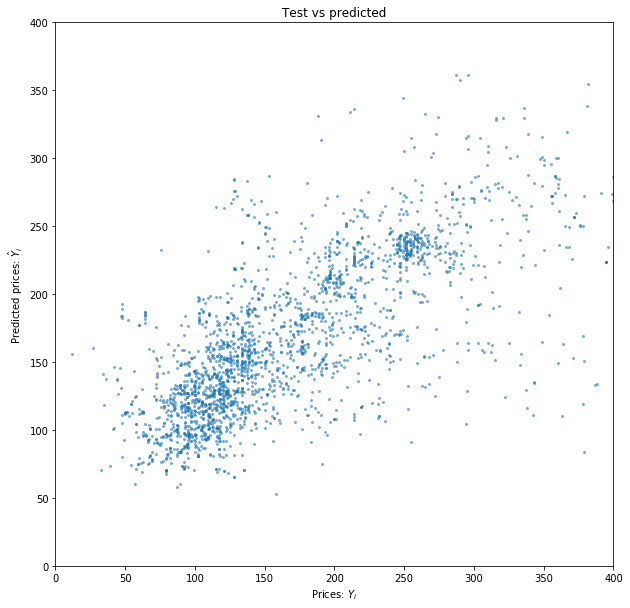

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# Plot outputs
plt.scatter(y_test,regr.predict(X_test), s=4, alpha=0.5)
#plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlim(0,400)
plt.ylim(0,400)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Test vs predicted")




```
Review Data
```



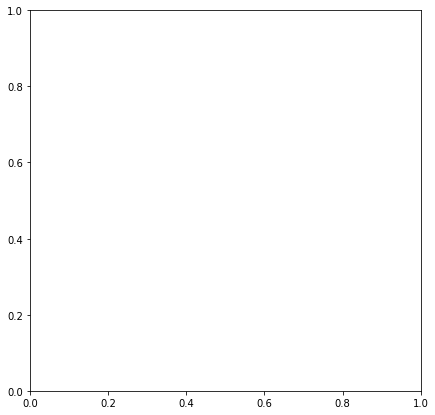

In [0]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

correct = y_test.SG_average_price.values
predicted = regr.predict(X_test).T[0]
error = predicted-correct
visdf = pd.DataFrame( {"Correct": correct, "Predicted": predicted, "Error": error})

(0, 400)

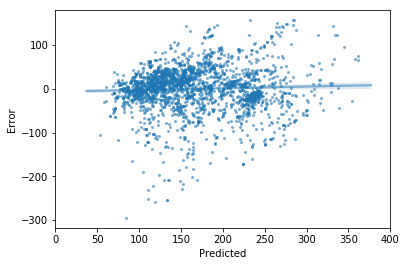

In [0]:
# Errors not correlated with predicted value

ax = sns.regplot(x="Predicted", y="Error", 
                 scatter_kws = {"s": 4, "alpha": 0.5},
                 line_kws = {"alpha": 0.5},
                 data=visdf)
#ax.set_ylim(0,400)
ax.set_xlim(0,400)

(0, 400)

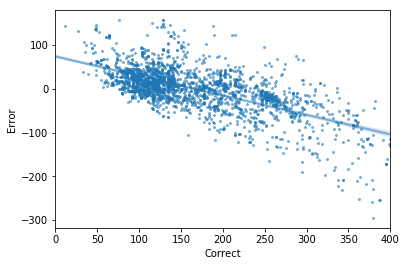

In [0]:
# Errors ARE correlated with correct value

ax = sns.regplot(x="Correct", y="Error", 
                 scatter_kws = {"s": 4, "alpha": 0.5},
                 line_kws = {"alpha": 0.5},
                 data=visdf)
#ax.set_ylim(0,400)
ax.set_xlim(0,400)

In [0]:
#Checking amount of concerts > 350

print(Y[Y > 350].count())

##Only 4.7% of total df
(523/11144)*100


SG_average_price    255
dtype: int64


4.69310839913855

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ad462940>]],
      dtype=object)

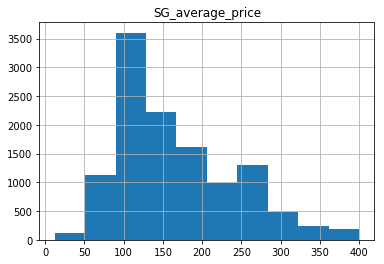

In [0]:
#Histogram of  price range 
Y.hist(bins=10)

In [0]:
#reg=LinearRegression()
#reg.fit(X,y)
#yp=reg.predict(X)
Y.mse_resid

AttributeError: ignored

---
 End of OLS



#Ridge


In [0]:
# Split 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=.3,random_state=3)


In [0]:
print ("X.shape:", X.shape)
print ("Y.shape:", Y.shape)
print ("X_train.shape:", X_train2.shape)
print ("X_test.shape:", X_test2.shape)
print ("y_train.shape:", y_train2.shape)
print ("y_test.shape:", y_test2.shape)

X.shape: (11861, 230)
Y.shape: (11861, 1)
X_train.shape: (8302, 230)
X_test.shape: (3559, 230)
y_train.shape: (8302, 1)
y_test.shape: (3559, 1)


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely

In [0]:
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.600262e-19
  overwrite_a=True).T


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
#Comparison with alpha value
rr100 = Ridge(alpha=100)
rr100.fit(X_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
train_score=lr.score(X_train, y_train)
test_score=lr.score(X_test, y_test)

In [0]:
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)

In [0]:
Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)

In [0]:
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)

linear regression train score: 0.5746194814486127
linear regression test score: 0.5324866583001516
ridge regression train score low alpha: 0.5746191683048305
ridge regression test score low alpha: 0.5325059214119183
ridge regression train score high alpha: 0.4870197895863806
ridge regression test score high alpha: 0.4475199718991806


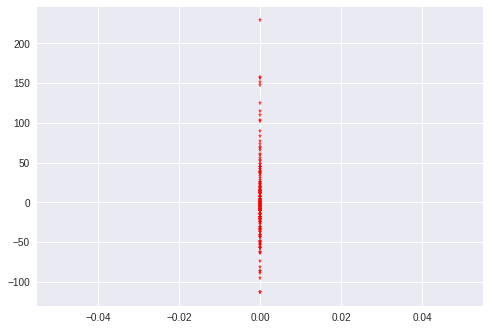

In [0]:
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7); # zorder for ordering the markers

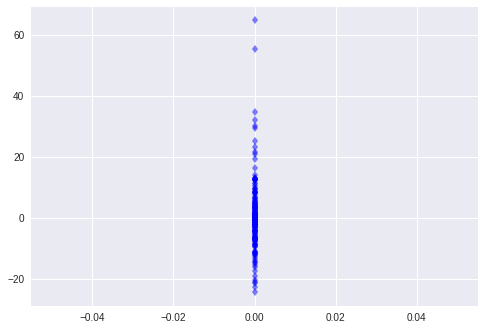

In [0]:
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$'); # alpha here is for transparency

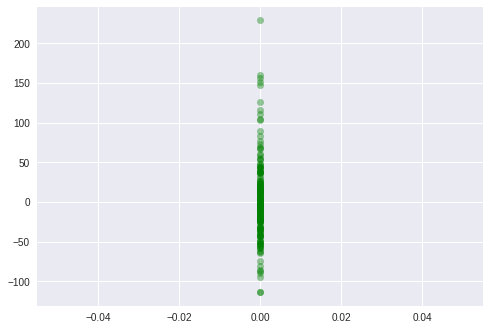

In [0]:
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression');

No handles with labels found to put in legend.


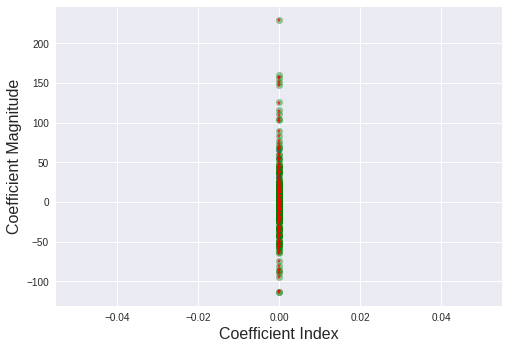

In [0]:
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',zorder=7); # zorder for ordering the markers,label=r'Ridge; $\alpha = 0.01$'
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue'); # alpha here is for transparency,label=r'Ridge; $\alpha = 100$'
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green'); #label='Linear Regression'
plt.legend(fontsize=13,loc=4)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.show()

#Lasso Regression


In [0]:
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are completely neglected
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [0]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=.3,random_state=31)


In [0]:
print ("X.shape:", X.shape)
print ("Y.shape:", Y.shape)
print ("X_train.shape:", X_train3.shape)
print ("X_test.shape:", X_test3.shape)
print ("y_train.shape:", y_train3.shape)
print ("y_test.shape:", y_test3.shape)

X.shape: (11861, 230)
Y.shape: (11861, 1)
X_train.shape: (8302, 230)
X_test.shape: (3559, 230)
y_train.shape: (8302, 1)
y_test.shape: (3559, 1)


In [0]:
lasso = Lasso()
lasso.fit(X_train3,y_train3)
train_score=lasso.score(X_train3,y_train3)
test_score=lasso.score(X_test3,y_test3)
coeff_used = np.sum(lasso.coef_!=0)

In [0]:
print ("training score:", train_score )
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.3651782539958146
test score:  0.337909204013355
number of features used:  15


In [0]:
#Alpha 0.01
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train3,y_train3)

train_score001=lasso001.score(X_train3,y_train3)
test_score001=lasso001.score(X_test3,y_test3)
coeff_used001 = np.sum(lasso001.coef_!=0)

In [0]:
print ("training score for alpha=0.01:", train_score001) 
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

training score for alpha=0.01: 0.5703521603306486
test score for alpha =0.01:  0.5423506248217163
number of features used: for alpha =0.01: 173


In [0]:
#ALPHA 0.0001
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train3,y_train3)

train_score00001=lasso00001.score(X_train3,y_train3)
test_score00001=lasso00001.score(X_test3,y_test3)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

In [0]:
print ("training score for alpha=0.0001:", train_score00001 )
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

training score for alpha=0.0001: 0.5737442482228854
test score for alpha =0.0001:  0.5420196314205772
number of features used: for alpha =0.0001: 207


In [0]:
lr = LinearRegression()
lr.fit(X_train3,y_train3)
lr_train_score=lr.score(X_train3,y_train3)
lr_test_score=lr.score(X_test3,y_test3)

In [0]:
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)

LR training score: 0.5737448527071141
LR test score:  0.5422375310790682


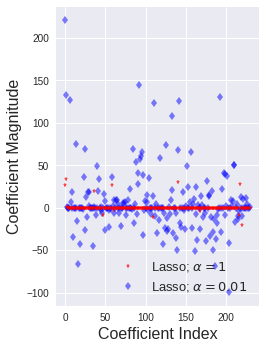

In [0]:
plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)

No handles with labels found to put in legend.


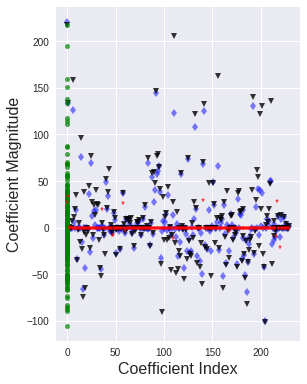

In [0]:
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',zorder=7) #  Lasso
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue') #  Lasso 0.01
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',) # Lasso 0.00001
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',zorder=2) #'Linear Regression'
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()